In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse551/Youtube_communities.txt
/kaggle/input/cse551/roadNet_Texas.txt
/kaggle/input/cse551/Undirected_Youtube_network.txt
/kaggle/input/cse551/Email-Enron.txt


In [2]:
!pip install hypernetx matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 10.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.

In [3]:
!pip install networkx numpy scikit-learn matplotlib
!pip install python-louvain

# Using Louvian and Spectral Clusturing 

In [ ]:
import networkx as nx
import hypernetx as hnx
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    jaccard_score,
    f1_score,
    precision_score,
    recall_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
# Step 1: Data Loading
def load_network_data(filename, max_edges=1000000):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H

In [ ]:
# Step 2: Louvain Clustering on Graph
def louvain_clustering(G):
    return community_louvain.best_partition(G)


# Step 3: Spectral Clustering on Hypergraph
def build_incidence_matrix(H):
    nodes = list(H.nodes)
    edges = list(H.edges)
    node_index = {node: i for i, node in enumerate(nodes)}
    edge_index = {edge: i for i, edge in enumerate(edges)}

    incidence_data = []
    row_indices = []
    col_indices = []

    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            if node in node_index:
                row_indices.append(node_index[node])
                col_indices.append(edge_index[edge_id])
                incidence_data.append(1)

    incidence_matrix = csr_matrix((incidence_data, (row_indices, col_indices)), shape=(len(H.nodes), len(H.edges)))
    return incidence_matrix

def hypergraph_spectral_clustering(H, num_clusters=5):
    nodes = list(H.nodes)
    incidence_matrix = build_incidence_matrix(H)
    adjacency = incidence_matrix @ incidence_matrix.T
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed')
    labels = spectral.fit_predict(adjacency.toarray())
    return {node: labels[i] for i, node in enumerate(nodes)}

In [ ]:
# Step 4: Finding Common Nodes between Graph and Hypergraph Communities
def find_common_nodes(graph_partition, hypergraph_partition):
    common_nodes = {}
    for node, community in graph_partition.items():
        if node in hypergraph_partition:
            common_nodes[node] = (community, hypergraph_partition[node])
    return common_nodes


# Step 5: Clustering on Common Nodes
def cluster_common_nodes(common_nodes, num_clusters=3):
    if len(common_nodes) < num_clusters:
        print(f"Not enough nodes to form {num_clusters} clusters. Using {len(common_nodes)} clusters instead.")
        num_clusters = len(common_nodes)
    
    common_node_ids = list(common_nodes.keys())
    common_labels = np.array([val[0] for val in common_nodes.values()]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clustered_labels = kmeans.fit_predict(common_labels)
    return common_node_ids, clustered_labels


In [ ]:
# Step 6: Calculate and Print Evaluation Metrics
def evaluate_clustering_metrics(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    jaccard = jaccard_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    # Calculate Purity
    contingency = contingency_matrix(true_labels, pred_labels)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Jaccard Similarity Index: {jaccard:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")


# Step 7: Visualize Clusters
def visualize_clusters(node_ids, labels):
    labels = np.array(labels).reshape(-1, 1)
    if labels.shape[1] < 2:
        print("Not enough dimensions for PCA. Plotting single feature as is.")
        plt.figure(figsize=(8, 4))
        plt.scatter(range(len(labels)), labels, c=labels.flatten(), cmap='viridis', alpha=0.8)
        plt.title("1D Visualization of Clusters for Common Nodes")
        plt.xlabel("Node Index")
        plt.ylabel("Cluster Label")
        plt.grid(True)
        plt.show()
    else:
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(labels)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels.flatten(), cmap='viridis', alpha=0.8)
        plt.title("Visualization of Clusters for Common Nodes")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.colorbar(scatter, label='Cluster Label')
        plt.grid(True)
        plt.show()

Graph loaded with 349580 nodes and 999996 edges.
Hypergraph loaded with 17221 hyperedges.


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Number of common nodes: 14651
NMI: 0.0004
ARI: -0.0001
Jaccard Similarity Index: 0.1656
F1 Score: 0.1873
Precision: 0.1926
Recall: 0.1980
Purity: 0.9326
Homogeneity: 0.0005
Completeness: 0.0004
V-measure: 0.0004
Not enough dimensions for PCA. Plotting single feature as is.


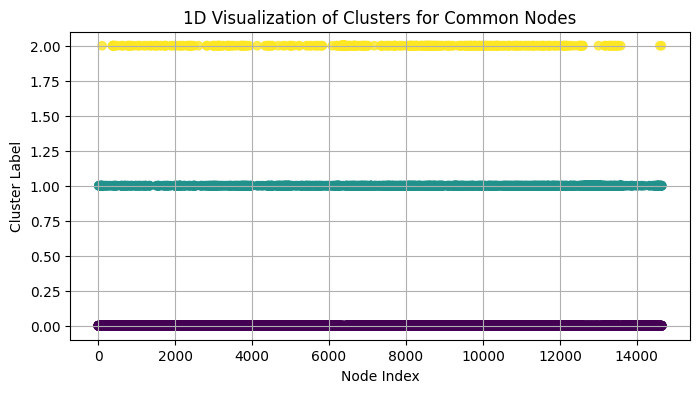

In [5]:

# Main Function
def main():
    filename = '/kaggle/input/cse551/Undirected_Youtube_network.txt'
    
    # Step 1: Load Network Data
    G, H = load_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")
    
    # Step 2: Louvain Clustering on Graph
    graph_partition = louvain_clustering(G)
    
    # Step 3: Spectral Clustering on Hypergraph
    hypergraph_partition = hypergraph_spectral_clustering(H, num_clusters=5)
    
    # Step 4: Finding Common Nodes
    common_nodes = find_common_nodes(graph_partition, hypergraph_partition)
    print(f"Number of common nodes: {len(common_nodes)}")
    
    # Step 5: Cluster on Common Nodes
    if len(common_nodes) > 0:
        common_node_ids, common_labels = cluster_common_nodes(common_nodes, num_clusters=3)
        
        # Step 6: Evaluate Clustering
        true_labels = [val[1] for val in common_nodes.values()]
        evaluate_clustering_metrics(true_labels, common_labels)
        
        # Step 7: Visualize Clusters
        visualize_clusters(common_node_ids, common_labels)
    else:
        print("No common nodes to cluster and visualize.")


if __name__ == "__main__":
    main()


# ----------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------

# Using Louvian

In [ ]:
import networkx as nx
import hypernetx as hnx
import community as community_louvain  # For Louvain on graph
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    jaccard_score, f1_score, precision_score,
    recall_score, homogeneity_score, completeness_score,
    v_measure_score
)
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
# Load YouTube network data as graph and hypergraph
def load_youtube_network_data(filename):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H

In [ ]:
# Apply Louvain on graph
def apply_louvain_on_graph(G):
    return community_louvain.best_partition(G)

# Apply Louvain on hypergraph via bipartite graph conversion
def apply_louvain_on_hypergraph(H):
    B = nx.Graph()
    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            B.add_edge(f"edge_{edge_id}", f"node_{node}")
    return community_louvain.best_partition(B)

In [ ]:
# Extract communities from partition dictionary
def extract_communities(partition, is_bipartite=False):
    communities = defaultdict(set)
    for node, community in partition.items():
        if is_bipartite and node.startswith("edge_"):
            continue
        actual_node = int(node.split('_')[1]) if is_bipartite and node.startswith("node_") else node
        communities[community].add(actual_node)
    return communities

In [ ]:
# Find common nodes between graph and hypergraph communities
def find_common_nodes(graph_communities, hypergraph_communities):
    graph_nodes = set(node for nodes in graph_communities.values() for node in nodes)
    hypergraph_nodes = set(node for nodes in hypergraph_communities.values() for node in nodes)
    return graph_nodes & hypergraph_nodes

In [ ]:
# Calculate evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    jaccard = jaccard_score(true_labels, pred_labels, average="macro")
    f1 = f1_score(true_labels, pred_labels, average="macro")
    precision = precision_score(true_labels, pred_labels, average="macro")
    recall = recall_score(true_labels, pred_labels, average="macro")
    purity = np.sum(np.amax(contingency_matrix(true_labels, pred_labels), axis=0)) / len(true_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Jaccard Similarity Index: {jaccard:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")

In [ ]:
# Cluster and visualize the common nodes
def cluster_and_visualize_common_nodes(common_nodes):
    G_common = nx.Graph()
    G_common.add_nodes_from(common_nodes)

    for node in common_nodes:
        neighbors = [n for n in common_nodes if abs(n - node) <= 5]
        G_common.add_edges_from((node, n) for n in neighbors if node != n)

    adjacency_matrix = nx.to_numpy_array(G_common)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(adjacency_matrix)
    labels = clustering.labels_

    # Group nodes by cluster labels
    clusters = defaultdict(list)
    for node, label in zip(common_nodes, labels):
        clusters[label].append(node)
    '''
    # Print clusters of common nodes
    for label, nodes in clusters.items():
        cluster_type = "Noise" if label == -1 else f"Cluster {label}"
        print(f"{cluster_type}: {nodes}")
    '''
    # Visualize clusters
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_common)
    colors = [f"C{label}" if label != -1 else 'black' for label in labels]

    nx.draw_networkx_nodes(G_common, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G_common, pos, alpha=0.5)
    plt.title("Clusters of Common Nodes between Graph and Hypergraph")
    plt.show()

    return labels

In [3]:

# Main function
def main():
    filename = '/kaggle/input/cse551/Undirected_Youtube_network.txt'

    # Load network as graph and hypergraph
    G, H = load_youtube_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    # Apply community detection
    graph_partition = apply_louvain_on_graph(G)
    hypergraph_partition = apply_louvain_on_hypergraph(H)

    # Extract communities from partitions
    graph_communities = extract_communities(graph_partition)
    hypergraph_communities = extract_communities(hypergraph_partition, is_bipartite=True)

    # Find common nodes
    common_nodes = find_common_nodes(graph_communities, hypergraph_communities)
    print(f"Number of common nodes between graph and hypergraph communities: {len(common_nodes)}")
    print("First 100 common nodes:", list(common_nodes)[:100])

    # Cluster and visualize common nodes
    #cluster_labels = cluster_and_visualize_common_nodes(common_nodes)

    # Prepare labels for evaluation metrics
    true_labels = [graph_partition[node] for node in common_nodes if node in graph_partition]
    pred_labels = [hypergraph_partition.get(f"node_{node}", -1) for node in common_nodes if f"node_{node}" in hypergraph_partition]

    # Calculate and print evaluation metrics
    calculate_evaluation_metrics(true_labels, pred_labels)

if __name__ == "__main__":
    main()


Graph loaded with 1134890 nodes and 2987624 edges.
Hypergraph loaded with 374785 hyperedges.
Number of common nodes between graph and hypergraph communities: 291987
First 100 common nodes: [524291, 625239, 524298, 524299, 524300, 1048590, 1048592, 1048593, 1048595, 1048596, 1048597, 1048598, 524309, 524311, 524312, 1048602, 1048603, 524307, 524317, 524318, 1048607, 524320, 524324, 854460, 524333, 524334, 524335, 1048625, 1048626, 1048629, 1048631, 524346, 524348, 1048640, 1048641, 1048642, 1048643, 524355, 524356, 524358, 524359, 1048648, 524352, 524362, 1048651, 1048652, 524365, 524364, 1048655, 1048654, 1048656, 1048657, 1048659, 1048660, 1048661, 1048662, 524375, 1048664, 524372, 524374, 524379, 1048668, 1048669, 524383, 524385, 524386, 524390, 1048680, 1048682, 1048683, 1048684, 1048685, 1048686, 1048687, 1048688, 524401, 524395, 1048690, 1048691, 524396, 524399, 1048694, 1048695, 1048696, 524409, 524411, 524412, 524414, 524415, 524416, 1048705, 524418, 1048704, 1048708, 524420, 10

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NMI: 0.4709
ARI: 0.0000
Jaccard Similarity Index: 0.0000
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Purity: 1.0000
Homogeneity: 1.0000
Completeness: 0.3080
V-measure: 0.4709


# ----------------------------------------------------------------------------